<a href="https://colab.research.google.com/github/Ritanjit/Energy_Efficiency_Evaluation_Cardiact_Arrest_Detection_Model/blob/main/Early_Detection_of_Cardiac_Arrest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early Detection of Cardiac Arrest - Classification of ECG Signals for Arrhythmia Disease Prediction

**What is Cardiac Arrest ?**

*Cardiac arrest is a sudden loss of heart function, breathing, and consciousness. It's an "electrical" problem where the heart's intricate electrical system, which dictates the heartbeat, malfunctions. This is different from a heart attack, which is a "plumbing" problem caused by blocked arteries. Early detection is critical because the chances of survival decrease dramatically with each passing minute.*

**How to detect Cardiac Arrest?**

*Biometric signals, especially the Electrocardiogram (ECG), are key to predicting cardiac arrest. An ECG records the electrical activity of the heart, and subtle changes in its pattern can be precursors to a life-threatening event. The goal is to train a model that can recognize these subtle, pre-arrest patterns in ECG data.*

**What this model does ?**

*This model classifies individual heartbeats into different arrhythmia categories using the MIT-BIH Arrhythmia Database. The 5 categories are:*

*N: Normal beat*

*L: Left bundle branch block beat*

*R: Right bundle branch block beat*

*A: Atrial premature beat*

*V: Ventricular ectopic beat*

*Massachusetts Institute of Technology (MIT) - Beth Israel Hospital (BIH) Database Links:*

*1. Training --> https://www.kaggle.com/datasets/taejoongyoon/mitbit-arrhythmia-database/data*

*2. Testing --> https://www.kaggle.com/datasets/shayanfazeli/heartbeat*


**How this relates to cardiac arrest ?**

*Certain arrhythmias, particularly Ventricular Tachycardia and Ventricular Fibrillation (which fall under the 'Ventricular' category), are often immediate precursors to sudden cardiac arrest.*

*This model detecs Ventricular Ectopic Arrhythmias. These are abnormal heartbeats originating from the lower chambers (the ventricles) of the heart. A frequent occurrence of these "V" beats, especially in specific patterns, is a major risk factor and can be a direct precursor to life-threatening conditions like Ventricular Tachycardia, which often leads to Sudden Cardiac Arrest.*

*Thus, the classification of beat types is a critical component of an early detection system for Cardiac Arrest.*

\



---

# 1. Input Setup and Data Preparation

 1.1 Imports

In [10]:
import numpy as np    # for array and matrix operations
import pandas as pd   # for operations using dataframes
import os   # for operations involving the google drive

import matplotlib.pyplot as plt   # for visualizations
import csv    # for comma separated valued files
import pywt   # for denoise signals thorugh wavelet transforms (reqd. for ECG data)

from scipy import stats   # for statistical operations
from sklearn.model_selection import train_test_split    # to split dataset for training and testing
from sklearn.utils import resample    # for handling imbalanced datasets (downsampling a majority class or upsampling a minority class)

from keras.models import Sequential   # for building my neural network architectures
from keras.layers import Conv1D     # for processing sequential data (signals in this case)
from keras.layers import AvgPool1D    # for downsampling input
from keras.layers import Flatten    #  for flatening multidimensional input to 1D vector
from keras.layers import Dense    # fully connected neural network layer for matrix-vector multiplication
from keras.layers import Dropout    # regularization technique to prevent overfitting
from keras.layers import Softmax    # to convert output into probability distribution
from keras.optimizers import Adam   # optimizer algorithm to minimize loss function
from keras.utils import to_categorical    # to convet integer labels to encoded vectors
from keras import regularizers    #  to prevent overfitting

1.2 Assigning custom settings to matplotlib properties

In [11]:
# %matplotlib inline    # not reqd for google colab (used this in jupyter for inline plot outputs)
plt.rcParams["figure.figsize"] = (15,5)     # size for all figues
plt.rcParams['lines.linewidth'] = 1     # width for plot lines
plt.rcParams['lines.color'] = 'b'     # blue color for plot lines
plt.rcParams['axes.grid'] = True    # grids for plot axes

1.3 Importing the dataset

In [12]:
# to manually mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Google Drive path for dataset folder
path = '/content/drive/MyDrive/Datasets/mitbih_database/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.4 Variables

In [13]:
# Globals
window_size    = 180    # no. of samples to consider before peak in ECG signal
# maximum_counting = 10000
classes        = ['N', 'L', 'R', 'A', 'V']    # for diff. types of heartbeats
n_classes      = len(classes)     # no of classes = 5
count_classes  = [0]*n_classes     # to count no. of instances of heartbeat classes processed
X, y           = [], []     # x - stores extract ECG data; y - stores corresponding class labels

1.5 List & separate .csv (signals) vs .txt (annotations)

In [14]:
# read all files and sort them alphabetically in a list
filenames   = sorted(os.listdir(path))

# add files into lists after sorting into .csv and .txt
records     = [path+f for f in filenames if f.endswith('.csv')]
annotations = [path+f for f in filenames if f.endswith('.txt')]

---

# 2. Data Preprocessing

2.1 Denoise function for noise reduction by performing Wavelet Transforms

In [16]:
def denoise(data):

    w        = pywt.Wavelet('sym4')     # selects sym4 wavelet for transformation
    maxlev   = pywt.dwt_max_level(len(data), w.dec_len)   # calculating highest possible decomposition level
    coeffs   = pywt.wavedec(data, 'sym4', level=maxlev)     # for removing noise based on the threshold value
    thresh   = 0.04 * max(abs(c) for c in coeffs[1])    # threshold for filtering noise (small coefficients)

    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], thresh)

    return pywt.waverec(coeffs, 'sym4')

2.2 Loop through each record and annotation pair

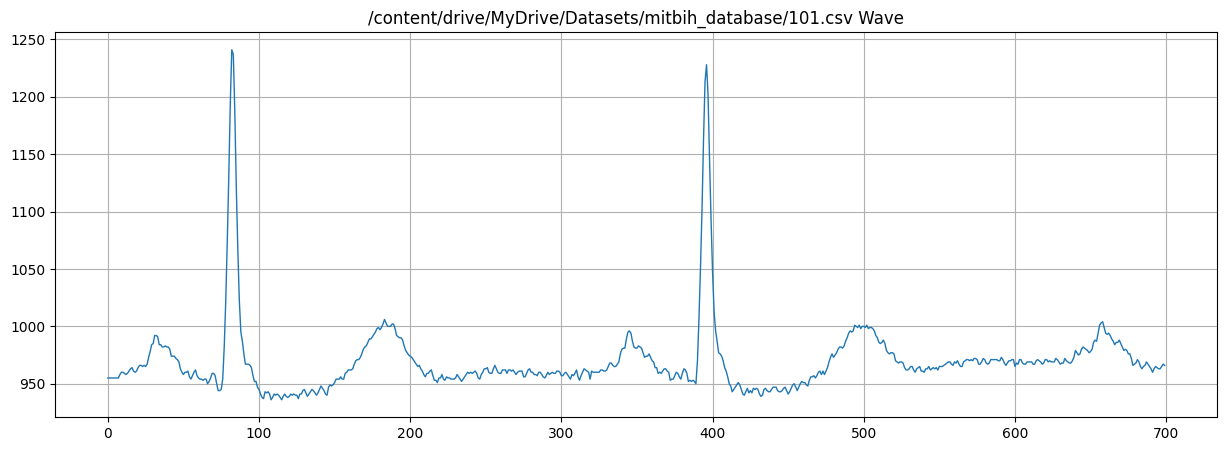

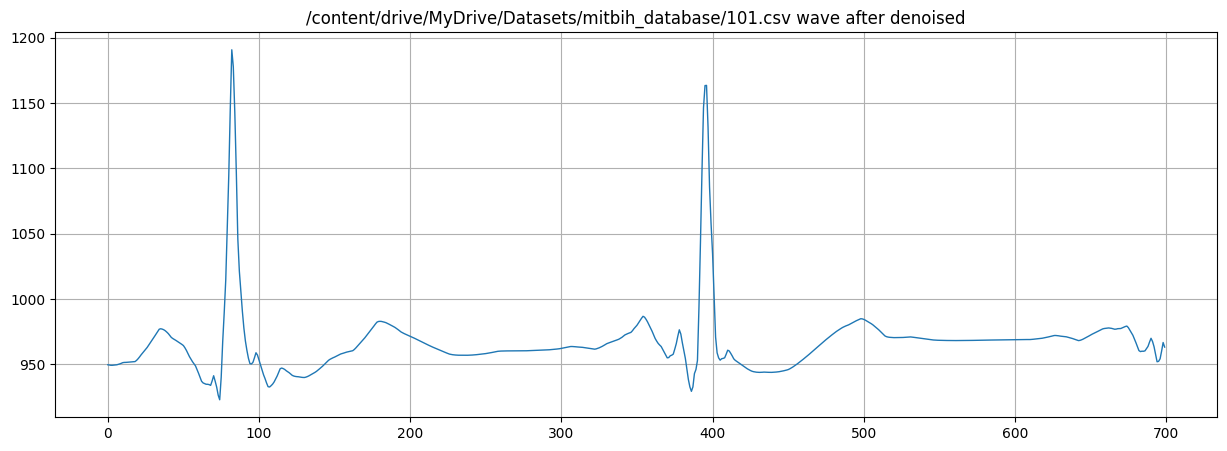

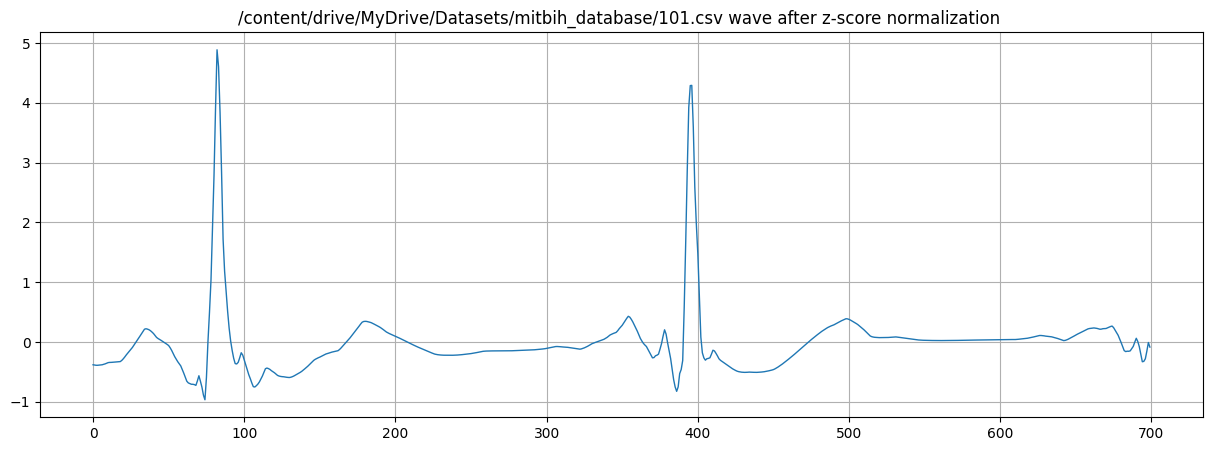

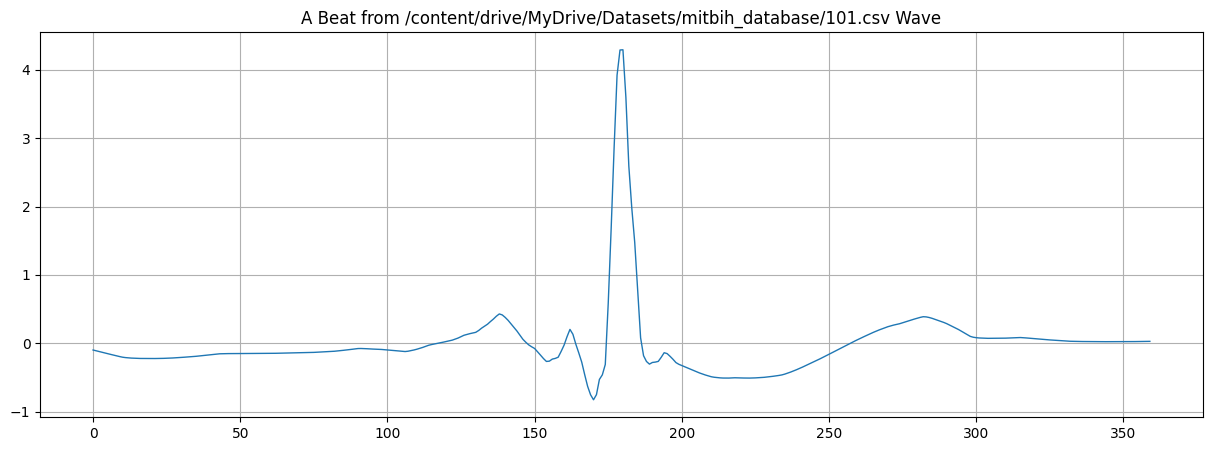

In [17]:
for rec_path, ann_path in zip(records, annotations):

    # load raw ECG samples into signals
    signals = []

    with open(rec_path, 'r') as f:
        reader = csv.reader(f)    # reader obj to iterate over lines in the csv file
        next(reader)    # skip header of csv file
        for row in reader:
            signals.append(int(row[1]))

    # Plot an example to the signals
    if rec_path == records[1]:
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    # print(signals[0].shape)

    signals = denoise(signals)    # denoise function to remove noise

    # print(signals[0].shape)

    # Plot an example to the signals
    if rec_path == records[1]:
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)   # normalization performed on the signals

    # Plot an example to the signals
    if rec_path == records[1]:
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # reading and processing annotations
    example_beat_printed = False
    with open(ann_path, 'r') as f:
        lines = f.readlines()[1:]   # read all lines and slice to exclude 1st line
    for line in lines:
        parts = list(filter(None, line.split()))    # split line into parts based on whitespace and remove empty strings (multi-spaces)
        pos   = int(parts[1])     # extracts and converts R-peak position into an integer
        label = parts[2]    # extracts label for heartbeat
        if label not in classes:    # this cross-checks the label with heartbeat classes and if not found, skips to next line
            continue
        idx = classes.index(label)    # storing index of label
        count_classes[idx] += 1   # counting how many times each heartbeat type have been processed

        # this if condition checks if the R-peak position is far enough from the beginning and end of the signal.
        # if satisfied, it extracts a complete window before and after the peak.
        if window_size <= pos < len(signals) - window_size:
            beat = signals[pos-window_size:pos+window_size]   # this extracts a segment that represesnts the heartbeat.

            # Plot an example beat
            if rec_path == records[1] and not example_beat_printed:
                plt.title("A Beat from " + records[1] + " Wave")
                plt.plot(beat)
                plt.show()
                example_beat_printed = True

            X.append(beat)   # adds heartbeat segment to the list
            y.append(idx)   # adds index of the hearbeat class to the list

2.3 Convert to arrays & inspect for data shape

In [18]:
X = np.array(X)   # shape: (total_beats, 360)
y = np.array(y)   # shape: (total_beats,)
print("Collected heartbeats:", X.shape, "Labels:", y.shape)

Collected heartbeats: (100012, 360) Labels: (100012,)


2.4 Plotting class distribution.

Before balancing:
 label
0    75011
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


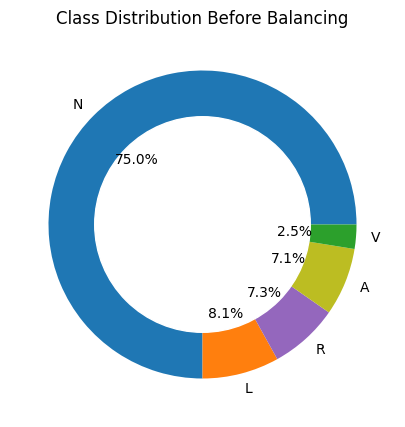

In [19]:
# converting preprocessed heartbeat data and class labels into dataframes
df = pd.DataFrame(X)
df['label'] = y

# plotting the current class distribution
per_class_before = df['label'].value_counts()     # counts how many instances of each unique value exist in the label column
print("Before balancing:\n", per_class_before)

# pie chart to represent the distribution
plt.figure(figsize=(10, 5))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class_before,
        labels=['N', 'L', 'R', 'A', 'V'],
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'],
        autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Class Distribution Before Balancing")
plt.show()

2.5 Balancing the class distribution

In [20]:
# spliting dataframe into dictionary of smaller of dataframes for each class label
dfs = {lbl: df[df.label == i] for i, lbl in enumerate(classes)}

# target sample size for each class after balancing
target_n = min(len(dfs['N']), 5000)  # capping normal beats at 5000
target_n = 5000                     # force cap to 5000 for each class after normal.

# down/up-sampling each class to meet target sample size
balanced_dfs = []
for i, lbl in enumerate(classes):
    cls_df = dfs[lbl]
    if len(cls_df) > target_n:
        cls_df = cls_df.sample(n=target_n, random_state=42)   # down-sampling by selecting random samples till target sample size is reached.
    else:
        cls_df = resample(cls_df, replace=True, n_samples=target_n, random_state=42)      # up-sampling by resampling with replacements until target sample size is reached.
    balanced_dfs.append(cls_df)

# random state = 42 ensure that the sampling is reproducible.

# concatenate and convert balanced_dfs list to dataframe & reshuffling the dataframe and resetting index to a new default index.
balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

2.6 Plotting the balanced class distribution

After balancing:
 label
1    5000
4    5000
2    5000
0    5000
3    5000
Name: count, dtype: int64


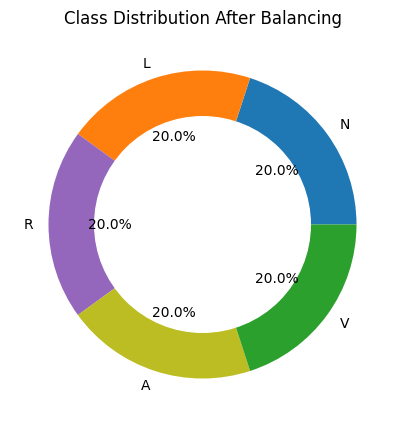

In [21]:
# to recount how many instances of each unique value exist in the label column
per_class_after = balanced_df['label'].value_counts()
print("After balancing:\n", per_class_after)

# pie chart to plot balanced class distribution
plt.figure(figsize=(10, 5))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class_after,
        labels=['N', 'L', 'R', 'A', 'V'],
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'],
        autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Class Distribution After Balancing")
plt.show()

In [22]:
# --- (Understanding the balanced DataFrame) ---
# Display the shape of the DataFrame
print("Shape of the dataset (balanced_df):", balanced_df.shape)

# Display the column names
print("\nColumn names (balanced_df):", balanced_df.columns)

# Display the data types of each column
print("\nData types (balanced_df):\n", balanced_df.dtypes)

# Display a statistical summary of the DataFrame
print("\nStatistical summary (balanced_df):\n", balanced_df.describe())

Shape of the dataset (balanced_df): (25000, 361)

Column names (balanced_df): Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           351,     352,     353,     354,     355,     356,     357,     358,
           359, 'label'],
      dtype='object', length=361)

Data types (balanced_df):
 0        float64
1        float64
2        float64
3        float64
4        float64
          ...   
356      float64
357      float64
358      float64
359      float64
label      int64
Length: 361, dtype: object

Statistical summary (balanced_df):
                   0             1             2             3             4  \
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean       0.063493      0.068089      0.071367      0.073939      0.075059   
std        0.998421      1.002942      1.006060      1.010214      1.011502   
min      -11.904145    -11.888252    -11.871984    -11.855504    -11.8391

2.7 separating balanced data back into values and labels

In [23]:
# Split back to X / y
X_bal = balanced_df.drop('label', axis=1).values    # removing label column to get the values only as an array
y_bal = balanced_df['label'].values   # extracting only the label column as an array

print("After balancing:", np.bincount(y_bal), "=> each class =", target_n)   # bincount calculates number of non-negative integer value in y_bal

After balancing: [5000 5000 5000 5000 5000] => each class = 5000


---

# 3. Building the model

3.1 Spliting dataset into training and testing sets

In [24]:
# spliting dataset - 80% for training and 20% for testing
train_df, test_df = train_test_split(balanced_df, test_size=0.2)

# Separating features(values) and labels for both train and test dataset
train_x = train_df.iloc[:,:-1].values.reshape(-1, 360, 1)
train_y = to_categorical(train_df.iloc[:,-1])

test_x  = test_df.iloc[:,:-1].values.reshape(-1, 360, 1)
test_y  = to_categorical(test_df.iloc[:,-1])

print(np.shape(train_y), np.shape(test_y))      # training value and label dataset
print(np.shape(train_x), np.shape(test_x))    # testing value and label dataset

(20000, 5) (5000, 5)
(20000, 360, 1) (5000, 360, 1)


3.2 Building the 1D Convolutional Neural Network (CNN) for time-series data (1D ECG Signals)

In [ ]:
# creating the layers of neural network
model = Sequential([
  Conv1D(16,13,padding='same',activation='relu', input_shape=(360,1)),
  AvgPool1D(3,2),
  Conv1D(32,15,padding='same',activation='relu'),
  AvgPool1D(3,2),
  Conv1D(64,17,padding='same',activation='relu'),
  AvgPool1D(3,2),
  Conv1D(128,19,padding='same',activation='relu'),
  AvgPool1D(3,2),   # giving the pooling layer window_size=3 and sliding_step=2 to reduce number of parameters and computations in the network
  Flatten(),    # flatens the output from pooling layers into 1D vector
  Dropout(0.5),   # setting 50% input units to 0 to reduce overfitting
  Dense(35, kernel_regularizer=regularizers.l2(1e-4)),    # first fully connected layer = 35 neuraons
  Dense(5,  kernel_regularizer=regularizers.l2(1e-4)),    # second fully connected layer = 5 output classes
  Softmax()     # activation function for output layer - converts output scores into a probability distribution over 5 classes.
])

# table for architecture of the neural network
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 360, 16)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 179, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 179, 32)        │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 89, 32)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 89, 64)         │        34,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 44, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44, 128)        │       155,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 21, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 35)             │        94,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,887 (1.12 MB)

 Trainable params: 292,887 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

3.3 Compiling model for training

In [ ]:
# configuring the model for classification
model.compile(loss='categorical_crossentropy',  # categorical_crossentropy for multi-class classification
              optimizer=Adam(),   # Adam - optimization algorithm to update model's weight during training
              metrics=['accuracy'])

3.4 Trainig the model

In [ ]:
# this model will run through 60 epochs for 36 samples per gradient update
history = model.fit(train_x, train_y,
                    batch_size=36, epochs=60,
                    validation_data=(test_x, test_y))

# the output history object is plotted beloq for loss convergence and accuracy

Epoch 1/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6445 - loss: 0.9023 - val_accuracy: 0.8654 - val_loss: 0.4346
Epoch 2/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8437 - loss: 0.4547 - val_accuracy: 0.8948 - val_loss: 0.3264
Epoch 3/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8777 - loss: 0.3540 - val_accuracy: 0.9016 - val_loss: 0.3020
Epoch 4/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8998 - loss: 0.3060 - val_accuracy: 0.9002 - val_loss: 0.3053
Epoch 5/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9098 - loss: 0.2749 - val_accuracy: 0.9284 - val_loss: 0.2286
Epoch 6/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9207 - loss: 0.2451 - val_accuracy: 0.9206 - val_loss: 0.2607
Epoch 7/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9236 - loss: 0.2339 - val_accuracy: 0.9334 - val_loss: 0.2196
Epoch 8/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9333 - loss: 0.2069 - val_accuracy: 

---

# 4. Evaluation

4.1 Plotting for loss convergence

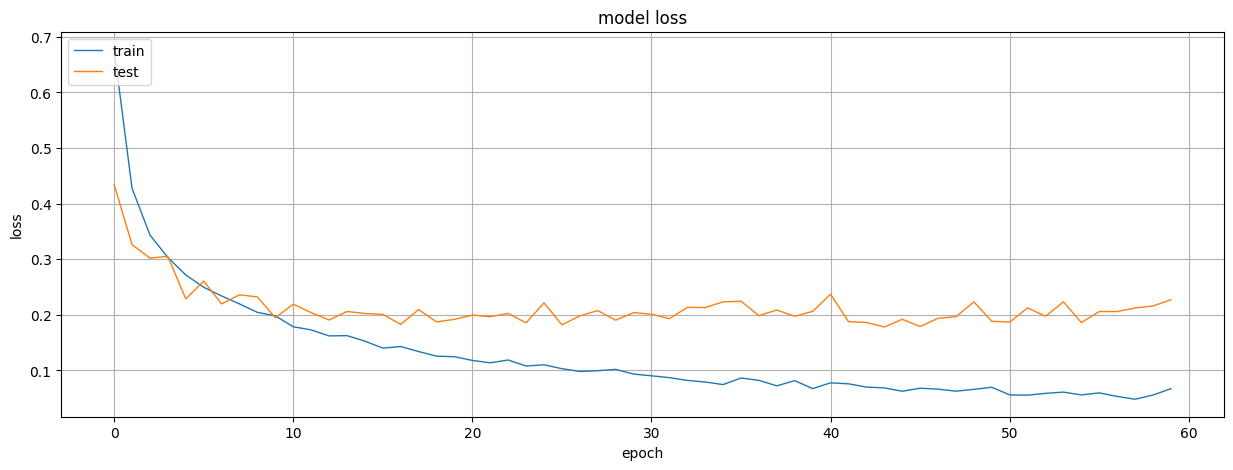

In [ ]:
# to summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

4.2 Plotting for accuracy

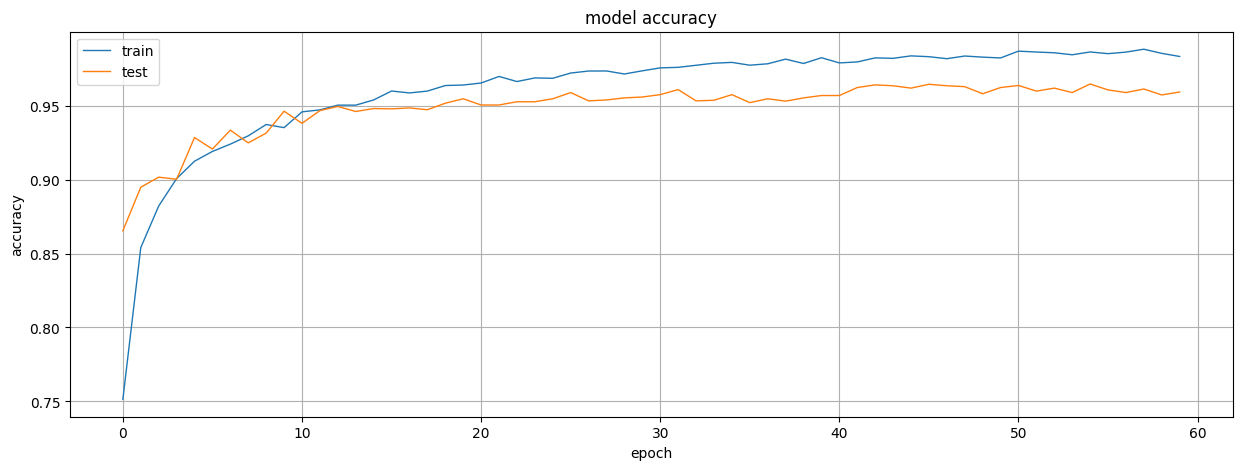

In [ ]:
# t0 summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

4.3 Evaluating the model for Loss and Accuracy

In [ ]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

acc_score = score[1]*100
print('Final Accuracy Score: ',round(acc_score,2),'%')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9558 - loss: 0.2698
Test Loss: 0.22709469497203827
Test accuracy: 0.9592000246047974
Final Accuracy Score:  95.92 %


---

# 5. Saving the model to google drive

In [ ]:
model.save('arrhythmia_cnn.h5')

In [ ]:
# saving model at custom google drive folder
save_path = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System'
model.save(os.path.join(save_path, 'arrhythmia_cnn.h5'))

---

# 6. Cardiac Arrest Alert System

6.1 Pre-requisite Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, csv, time
import numpy as np
import pywt
from scipy import stats
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


6.2 load trained model

In [ ]:
model_path = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/arrhythmia_cnn.h5'
model = load_model(model_path)
print("Model loaded. Input shape:", model.input_shape)

Model loaded. Input shape: (None, 360, 1)


6.3 Re‐defined preprocessing (matching the training)

In [ ]:
window_size = 180   # samples before & after R-peak
classes     = ['N','L','R','A','V']

def denoise(sig):
    w     = pywt.Wavelet('sym4')
    maxlev= pywt.dwt_max_level(len(sig), w.dec_len)
    coeffs= pywt.wavedec(sig, 'sym4', level=maxlev)
    thresh= 0.04 * max(abs(c) for c in coeffs[1])
    for i in range(1,len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], thresh)
    return pywt.waverec(coeffs, 'sym4')

6.4 helper function to process a long ECG array in sliding windows

In [ ]:
def sliding_inference(ecg_signal, step=50, alert_thresh=0.7):
    n = len(ecg_signal)
    alerts = []
    for center in range(window_size, n-window_size, step):
        window = ecg_signal[center-window_size:center+window_size]
        # denoise + normalize
        w = denoise(window)
        w = stats.zscore(w)
        # reshape for model: (1,360,1)
        inp = w.reshape(1, len(w), 1)
        probs = model.predict(inp, verbose=0)[0]
        # check ventricular class probability
        if probs[4] > alert_thresh:
            t_sec = center / 360.0   # if sampling at 360Hz → seconds
            alerts.append((t_sec, probs[4]))
    return alerts

6.5 testing the model by simulating on a different ECG dataset

In [ ]:
ecg_file = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/mitbih_test.csv/mitbih_test.csv'
signal = []
with open(ecg_file) as f:
    rdr = csv.reader(f)
    next(rdr)
    for row in rdr:
        signal.append(float(row[1]))
signal = np.array(signal)

alerts = sliding_inference(signal, step=50, alert_thresh=0.8)

if alerts:
    print(f"⚠️ {len(alerts)} alert(s) triggered:")
    for t, p in alerts:
        print(f" • at {t:.1f}s → P(ventricular) = {p:.2f}")
else:
    print("✅ No dangerous events detected.")

⚠️ 74 alert(s) triggered:
 • at 0.6s → P(ventricular) = 0.88
 • at 3.3s → P(ventricular) = 0.98
 • at 3.6s → P(ventricular) = 0.98
 • at 3.8s → P(ventricular) = 0.92
 • at 4.4s → P(ventricular) = 1.00
 • at 5.2s → P(ventricular) = 0.87
 • at 5.9s → P(ventricular) = 0.83
 • at 7.2s → P(ventricular) = 0.90
 • at 7.7s → P(ventricular) = 0.94
 • at 8.3s → P(ventricular) = 0.95
 • at 8.4s → P(ventricular) = 0.99
 • at 9.7s → P(ventricular) = 0.85
 • at 10.1s → P(ventricular) = 0.93
 • at 10.4s → P(ventricular) = 0.90
 • at 12.0s → P(ventricular) = 0.92
 • at 13.8s → P(ventricular) = 0.81
 • at 14.5s → P(ventricular) = 1.00
 • at 16.2s → P(ventricular) = 0.98
 • at 17.0s → P(ventricular) = 0.80
 • at 17.2s → P(ventricular) = 0.95
 • at 17.6s → P(ventricular) = 0.99
 • at 17.9s → P(ventricular) = 0.98
 • at 18.0s → P(ventricular) = 0.94
 • at 19.2s → P(ventricular) = 0.88
 • at 20.2s → P(ventricular) = 1.00
 • at 21.1s → P(ventricular) = 0.82
 • at 22.2s → P(ventricular) = 0.93
 • at 22.6s → 

6.6 Ploting to visualize where alerts occured

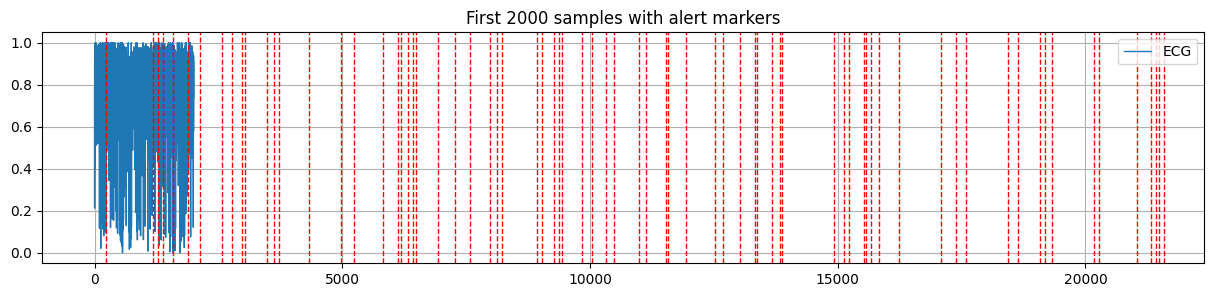

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(signal[:2000], label='ECG')
for t, _ in alerts:
    idx = int(t * 360)
    plt.axvline(idx, color='red', linestyle='--')
plt.legend(); plt.title("First 2000 samples with alert markers"); plt.show()

In [ ]:
# converting preprocessed heartbeat data and class labels into dataframes
df = pd.DataFrame(X)
df['label'] = y

# Describe the original dataset files
print("Understanding the MIT-BIH ECG Signals Dataset:")
print("The dataset consists of pairs of .csv and .txt files for each record.")
print(f"- .csv files (e.g., {os.path.basename(records[0])}): Contain the raw ECG signal data.")
print(f"- .txt files (e.g., {os.path.basename(annotations[0])}): Contain annotations, including the R-peak positions and the type of heartbeat (arrhythmia class).")
print(f"\nEach heartbeat is extracted from the raw signal based on the R-peak position and a window size of {window_size} samples before and after the peak.")
print(f"The extracted heartbeats are then stored in the pandas DataFrame 'df' with shape {df.shape}.")

# Display the shape of the DataFrame
print("\nShape of the processed heartbeat dataset (DataFrame):", df.shape)

# Display the column names
print("\nColumn names (numerical indices represent time steps/features, 'label' is the class):", df.columns.tolist())

# Display the data types of each column
print("\nData types:\n", df.dtypes)

# Display a statistical summary of the DataFrame
print("\nStatistical summary of the processed heartbeat data:\n", df.describe())

Understanding the MIT-BIH ECG Signals Dataset:
The dataset consists of pairs of .csv and .txt files for each record.
- .csv files (e.g., 100.csv): Contain the raw ECG signal data.
- .txt files (e.g., 100annotations.txt): Contain annotations, including the R-peak positions and the type of heartbeat (arrhythmia class).

Each heartbeat is extracted from the raw signal based on the R-peak position and a window size of 180 samples before and after the peak.
The extracted heartbeats are then stored in the pandas DataFrame 'df' with shape (100012, 361).

Shape of the processed heartbeat dataset (DataFrame): (100012, 361)

Column names (numerical indices represent time steps/features, 'label' is the class): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 

---

#-------------------------------------------------------------------------------------------------------------------------------------------

# Making ML model lightweight for deployment on edge devices

To make the developed ML model lightweight for deployment into resource constraints of edge devices, I have used the following approaches:

1. Model Quantization (Post-Training): this reduces model size by converting weights from 32-bit floats to smaller representations (16-bit/8-bit).

2. Knowledge Distillation: this trains a smaller "student" model using predictions from the original "teacher" model.

# 1. Re-building the model to use tensorflow.keras instead of standalone keras

Note: I have rebuilt the model using tensoflow.keras in order to use tensorflow lite library. Traditional stand-alone keras does not allow the usage of tensorflow lite.

3.1b Spliting dataset into training and testing sets

In [25]:
from tensorflow.keras.utils import to_categorical  # ensure using tf.keras

train_df, test_df = train_test_split(balanced_df, test_size=0.2)

train_x = train_df.iloc[:, :-1].values.reshape(-1, 360, 1)
train_y = to_categorical(train_df.iloc[:, -1])

test_x  = test_df.iloc[:, :-1].values.reshape(-1, 360, 1)
test_y  = to_categorical(test_df.iloc[:, -1])

print(np.shape(train_y), np.shape(test_y))
print(np.shape(train_x), np.shape(test_x))

(20000, 5) (5000, 5)
(20000, 360, 1) (5000, 360, 1)


3.2b Building CNN using `tf.keras`

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(16, 13, padding='same', activation='relu', input_shape=(360, 1)),
    AvgPool1D(pool_size=3, strides=2),

    Conv1D(32, 15, padding='same', activation='relu'),
    AvgPool1D(pool_size=3, strides=2),

    Conv1D(64, 17, padding='same', activation='relu'),
    AvgPool1D(pool_size=3, strides=2),

    Conv1D(128, 19, padding='same', activation='relu'),
    AvgPool1D(pool_size=3, strides=2),

    Flatten(),
    Dropout(0.5),
    Dense(35, kernel_regularizer=regularizers.l2(1e-4)),
    Dense(5,  kernel_regularizer=regularizers.l2(1e-4)),
    Softmax()
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 360, 16)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 179, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 179, 32)        │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 89, 32)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 89, 64)         │        34,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 44, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44, 128)        │       155,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 21, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 35)             │        94,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,887 (1.12 MB)

 Trainable params: 292,887 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

3.3b Compile model using `tf.keras`

In [27]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

3.4b Train model

In [ ]:
history = model.fit(
    train_x, train_y,
    batch_size=36,
    epochs=60,
    validation_data=(test_x, test_y)
)


Epoch 1/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6577 - loss: 0.9001 - val_accuracy: 0.8372 - val_loss: 0.4584
Epoch 2/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8483 - loss: 0.4313 - val_accuracy: 0.8922 - val_loss: 0.3388
Epoch 3/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8847 - loss: 0.3389 - val_accuracy: 0.9048 - val_loss: 0.2951
Epoch 4/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9042 - loss: 0.2933 - val_accuracy: 0.9114 - val_loss: 0.2705
Epoch 5/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9126 - loss: 0.2629 - val_accuracy: 0.9222 - val_loss: 0.2433
Epoch 6/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9215 - loss: 0.2423 - val_accuracy: 0.9234 - val_loss: 0.2317
Epoch 7/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9310 - loss: 0.2192 - val_accuracy: 0.9310 - val_loss: 0.2269
Epoch 8/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9356 - loss: 0.2042 - val_accuracy: 

In [ ]:
# Save as HDF5 format (.h5)
model.save('tf_cardiac_cnn_model.h5')
print("✅ Model saved locally in Colab as 'tf_cardiac_cnn_model.h5'")

# Define path for  Google Drive
drive_path = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System'

# Save the model as HDF5 (.h5) file in google drive
model.save(os.path.join(drive_path, 'tf_cardiac_cnn_model.h5'))
print(f"✅ Model saved to Google Drive at: {drive_path}/tf_cardiac_cnn_model.h5")

✅ Model saved locally in Colab as 'tf_cardiac_cnn_model.h5'
✅ Model saved to Google Drive at: /content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_cardiac_cnn_model.h5


In [ ]:
# Save as TensorFlow SavedModel format (.pb file with assets and variables)
export_path = os.path.join(drive_path, 'tf_cardiac_model')
model.export(export_path)
print(f"✅ Model saved to Google Drive at: {export_path} (TensorFlow SavedModel format)")

Saved artifact at '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_cardiac_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 360, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  131928745727312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928745731536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928745729232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928745727120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928745729040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928745729808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928756968464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928756966352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928756969232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13192875696

# 2. Model Quantization (Post-Training)

Reduces model size by converting weights from 32-bit floats to smaller representations (16-bit/8-bit).

Benefits:

* 50-75% size reduction

* 2-3x faster inference

* Minimal accuracy loss

In [2]:
# Install required package
!pip install tensorflow

import tensorflow as tf

In [ ]:
# Load original model
model = tf.keras.models.load_model('/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_cardiac_cnn_model.h5')

# Convert to TensorFlow Lite with FP16 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # FP16 quantization
tflite_model = converter.convert()

# Save quantized model
with open('tf_quantized_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp3mh9a8xv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 360, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  131930828523472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131930828524432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131930828528464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131930828523856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131930828528656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928756976144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928756976336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928756975760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928756976912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928767326224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131928767329872: Ten

In [ ]:
# Compare the file sizes

import os

original_model_path = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_cardiac_cnn_model.h5'
quantized_model_path = 'tf_quantized_model.tflite' # saved in the current working directory

# Get file sizes in bytes
original_model_size = os.path.getsize(original_model_path)
quantized_model_size = os.path.getsize(quantized_model_path)

# Convert to a more readable format (e.g., KB or MB)
def convert_bytes(num):
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

print(f"Original model size: {convert_bytes(original_model_size)}")
print(f"Quantized model size: {convert_bytes(quantized_model_size)}")

# Calculate reduction
reduction_percentage = ((original_model_size - quantized_model_size) / original_model_size) * 100
print(f"Size reduction: {reduction_percentage:.2f}%")

Original model size: 1.2 MB
Quantized model size: 581.4 KB
Size reduction: 51.24%


In [ ]:
# Save quantized model to Google Drive

import shutil   # Using shutil.copy2 to save model in order to preserving metadata

drive_destination_path = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_quantized_model.tflite'

# Copy the quantized model to Google Drive
try:
    # Ensure the destination directory exists
    os.makedirs(os.path.dirname(drive_destination_path), exist_ok=True)

    shutil.copy2(quantized_model_path, drive_destination_path)
    print(f"Quantized model successfully saved to Google Drive at: {drive_destination_path}")

except FileNotFoundError:
    print(f"Error: Source file '{quantized_model_path}' not found.")
except Exception as e:
    print(f"Error saving quantized model to Google Drive: {e}")

Quantized model successfully saved to Google Drive at: /content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_quantized_model.tflite


---

# 3. Knowledge Distillation

Trains a smaller "student" model using predictions from the original "teacher" model.

In [ ]:
# Student model (50% smaller)
student_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(8, 13, activation='relu', input_shape=(360,1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Distillation setup
distilled_model = tf.keras.models.clone_model(student_model)
distilled_model.compile(optimizer='adam',
                        loss='categorical_crossentropy', # Using crossentropy for simplicity
                        metrics=['accuracy'])

# Soft labels from teacher
try:
    teacher_predictions = model.predict(train_x)
except NameError:
    print("Error: 'model' (the teacher model) is not defined. Please ensure the original model is built or loaded.")
    teacher_predictions = None # Set to None to avoid further errors if model is not defined

if teacher_predictions is not None:
    # Train student using teacher's soft labels
    print("\nTraining the student model on teacher's soft labels...")
    distilled_history = distilled_model.fit(
        train_x,
        teacher_predictions,  # Train on soft labels
        epochs=30,
        validation_data=(test_x, test_y)
    )

    # Evaluate the distilled model
    print("\nEvaluating the distilled model:")
    distilled_score = distilled_model.evaluate(test_x, test_y)
    print('Distilled Model Test Loss:', distilled_score[0])
    print('Distilled Model Test accuracy:', distilled_score[1])
    distilled_acc_score = distilled_score[1]*100
    print('Distilled Model Final Accuracy Score: ',round(distilled_acc_score,2),'%')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training the student model on teacher's soft labels...
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6278 - loss: 0.9913 - val_accuracy: 0.7892 - val_loss: 0.6227
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8078 - loss: 0.5686 - val_accuracy: 0.8106 - val_loss: 0.5683
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8220 - loss: 0.5349 - val_accuracy: 0.8036 - val_loss: 0.5648
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8238 - loss: 0.5322 - val_accuracy: 0.8226 - val_loss: 0.5309
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8384 - loss: 0.5042 - val_accuracy: 0.8138 - val_loss: 0.5448
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8371 - loss: 0.4989 - val_accuracy: 0.8338 - val_loss: 0.5069
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8408 - loss: 0.4877 - val_accuracy: 0.8364 - val_loss: 0.5014
Epoch 8

In [ ]:
# save the distilled model
distilled_model.save('distilled_model.h5')

In [ ]:
import os
import shutil

local_model_path = 'distilled_model.h5'

drive_destination_path = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/distilled_model.h5'

if not os.path.exists(local_model_path):
    print(f"Error: Local model file '{local_model_path}' not found.")
else:
    # Copy the distilled model to Google Drive
    try:
        os.makedirs(os.path.dirname(drive_destination_path), exist_ok=True)

        # Use shutil.copy2 to preserving metadata
        shutil.copy2(local_model_path, drive_destination_path)
        print(f"✅ Distilled model successfully saved to Google Drive at: {drive_destination_path}")

    except Exception as e:
        print(f"Error saving distilled model to Google Drive: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Distilled model successfully saved to Google Drive at: /content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/distilled_model.h5


---

# 4. Evaluation / Benchmark models:

In [ ]:
# Compare size and latency
original_size = os.path.getsize('tf_cardiac_cnn_model.h5')
quantized_size = os.path.getsize('tf_quantized_model.tflite')
print(f"Size reduction: {(1 - quantized_size/original_size)*100:.1f}%")

# Latency test
import time
start = time.time()
model.predict(test_x[0:1])
print(f"Latency: {(time.time()-start)*1000:.2f}ms")

Size reduction: 51.2%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Latency: 69.98ms


In [ ]:
# Install required packages
!pip install tensorflow
!pip install tensorflow-model-optimization

import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
# Define paths
MODEL_DIR = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System'
ORIGINAL_MODEL = os.path.join(MODEL_DIR, 'tf_cardiac_cnn_model.h5')
DISTILLED_MODEL = os.path.join(MODEL_DIR, 'distilled_model.h5')
QUANTIZED_MODEL = os.path.join(MODEL_DIR, 'tf_quantized_model.tflite')

In [ ]:
# Model Loading and Preparation

print("\n=== Loading Models ===")

# Load original model
original_model = load_model(ORIGINAL_MODEL)
print(f"✅ Original model loaded ({ORIGINAL_MODEL})")

# Load distilled model
distilled_model = load_model(DISTILLED_MODEL)
print(f"✅ Distilled model loaded ({DISTILLED_MODEL})")

# Load quantized model
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"✅ Quantized model loaded ({QUANTIZED_MODEL})")


=== Loading Models ===
✅ Original model loaded (/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_cardiac_cnn_model.h5)


✅ Distilled model loaded (/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/distilled_model.h5)
✅ Quantized model loaded (/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_quantized_model.tflite)


In [ ]:
# Evaluation Functions

def evaluate_keras_model(model, x_test, y_test, num_samples=100):
    """Evaluate standard Keras model"""
    # Accuracy
    _, acc = model.evaluate(x_test, y_test, verbose=0)

    # Latency (average over num_samples)
    start = time.time()
    for _ in range(num_samples):
        model.predict(x_test[0:1], verbose=0)
    latency = (time.time() - start) * 1000 / num_samples

    # Model size
    model_path = 'temp_model.h5'
    model.save(model_path)
    size = os.path.getsize(model_path) / (1024 * 1024)  # in MB
    os.remove(model_path)

    return acc, latency, size

def evaluate_tflite_model(interpreter, x_test, y_test, num_samples=100):
    """Evaluate TFLite model"""
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Accuracy
    correct = 0
    total = len(x_test)

    for i in range(total):
        # Convert the input data to FLOAT32
        input_data = x_test[i:i+1].astype(np.float32)
        interpreter.set_tensor(input_index, input_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)
        if np.argmax(output) == np.argmax(y_test[i]):
            correct += 1
    acc = correct / total

    # Latency (average over num_samples)
    start = time.time()
    for _ in range(num_samples):
        # Convert the input data to FLOAT32 for latency test as well
        input_data = x_test[0:1].astype(np.float32)
        interpreter.set_tensor(input_index, input_data)
        interpreter.invoke()
    latency = (time.time() - start) * 1000 / num_samples

    # Model size
    size = os.path.getsize(QUANTIZED_MODEL) / (1024 * 1024)  # in MB

    return acc, latency, size

In [ ]:
# Evaluations

print("\n=== Evaluating Models ===")

# Evaluate original model
print("Evaluating original model...")
orig_acc, orig_latency, orig_size = evaluate_keras_model(original_model, test_x, test_y)
print(f"Original Model - Accuracy: {orig_acc:.4f}, Latency: {orig_latency:.2f}ms, Size: {orig_size:.2f}MB")

# Evaluate distilled model
print("Evaluating distilled model...")
dist_acc, dist_latency, dist_size = evaluate_keras_model(distilled_model, test_x, test_y)
print(f"Distilled Model - Accuracy: {dist_acc:.4f}, Latency: {dist_latency:.2f}ms, Size: {dist_size:.2f}MB")

# Evaluate quantized model
print("Evaluating quantized model...")
quant_acc, quant_latency, quant_size = evaluate_tflite_model(interpreter, test_x, test_y)
print(f"Quantized Model - Accuracy: {quant_acc:.4f}, Latency: {quant_latency:.2f}ms, Size: {quant_size:.2f}MB")


=== Evaluating Models ===
Evaluating original model...


Original Model - Accuracy: 0.9882, Latency: 68.17ms, Size: 1.16MB
Evaluating distilled model...


Distilled Model - Accuracy: 0.8584, Latency: 83.18ms, Size: 0.05MB
Evaluating quantized model...
Quantized Model - Accuracy: 0.9882, Latency: 0.34ms, Size: 0.57MB


In [ ]:
# Comparison Metrics / Benchmarks

print("\n=== Comparison Metrics ===")

# Create comparison table
metrics = {
    'Model': ['Original', 'Distilled', 'Quantized'],
    'Accuracy': [orig_acc, dist_acc, quant_acc],
    'Latency (ms)': [orig_latency, dist_latency, quant_latency],
    'Size (MB)': [orig_size, dist_size, quant_size],
    'Size Reduction %': [0, (1-dist_size/orig_size)*100, (1-quant_size/orig_size)*100],
    'Speedup Factor': [1, orig_latency/dist_latency, orig_latency/quant_latency]
}

import pandas as pd
df_compare = pd.DataFrame(metrics)
print(df_compare)


=== Comparison Metrics ===
       Model  Accuracy  Latency (ms)  Size (MB)  Size Reduction %  \
0   Original    0.9882     68.165555   1.164505          0.000000   
1  Distilled    0.8584     83.184857   0.047340         95.934720   
2  Quantized    0.9882      0.335867   0.567806         51.240549   

   Speedup Factor  
0        1.000000  
1        0.819447  
2      202.953767  



=== 📈 Generating Side-by-Side Visualizations ===


/tmp/ipython-input-132-1114613506.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


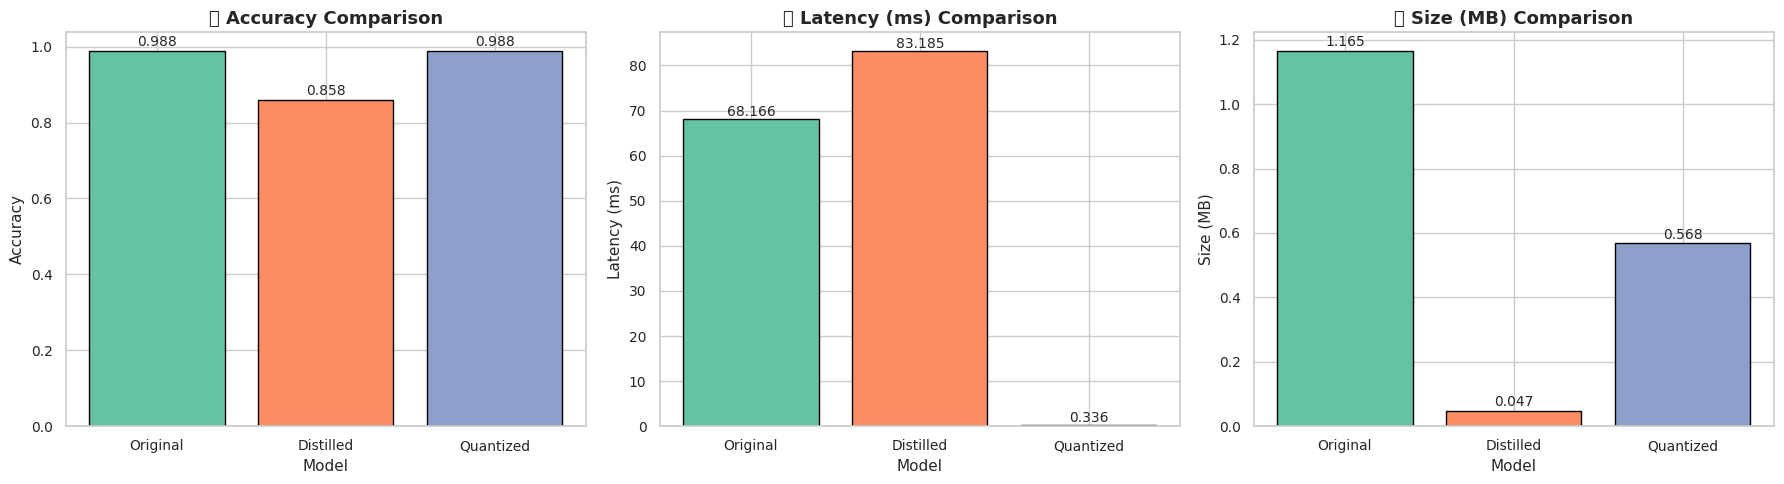

In [ ]:
# Visualization of Model Metrics / Benchmarks

import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== 📈 Generating Side-by-Side Visualizations ===")

# seaborn theme
sns.set_theme(style="whitegrid")
colors = sns.color_palette("Set2")

# Metric labels and chart configs
metric_titles = ['Accuracy', 'Latency (ms)', 'Size (MB)']
metric_labels = ['Accuracy', 'Latency (ms)', 'Size (MB)']

# subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, ax in enumerate(axes):
    metric = metric_titles[idx]
    bars = ax.bar(metrics['Model'], metrics[metric], color=colors, edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    ax.set_title(f'📊 {metric} Comparison', fontsize=13, weight='bold')
    ax.set_ylabel(metric_labels[idx], fontsize=11)
    ax.set_xlabel('Model', fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Conclusion: Best Lightweight Model

print("\n=== Best Lightweight Model Recommendation ===")

# Calculate weighted score
accuracy_weight = 0.5
latency_weight = 0.3
size_weight = 0.2

# Normalize metrics
max_acc = max(metrics['Accuracy'])
min_latency = min(metrics['Latency (ms)'])
min_size = min(metrics['Size (MB)'])

dist_score = (
    (dist_acc/max_acc)*accuracy_weight +
    (min_latency/dist_latency)*latency_weight +
    (min_size/dist_size)*size_weight
)

quant_score = (
    (quant_acc/max_acc)*accuracy_weight +
    (min_latency/quant_latency)*latency_weight +
    (min_size/quant_size)*size_weight
)

if dist_score > quant_score:
    print("Distilled model is better for deployment (Score: {:.2f} vs {:.2f})".format(dist_score, quant_score))
    print("Recommended for use when moderate size reduction is needed with minimal accuracy loss")
else:
    print("Quantized model is better for deployment (Score: {:.2f} vs {:.2f})".format(quant_score, dist_score))
    print("Recommended for use when maximum size reduction and speed are critical")

print("\n=== Conclusion ===")
print("1. For high accuracy needs: Use original model (Size: {:.2f}MB)".format(orig_size))
print("2. For balanced needs: Use distilled model (Size: {:.2f}MB, {:.2%} of original)".format(dist_size, dist_size/orig_size))
print("3. For most constrained devices: Use quantized model (Size: {:.2f}MB, {:.2%} of original)".format(quant_size, quant_size/orig_size))


=== Best Lightweight Model Recommendation ===
Quantized model is better for deployment (Score: 0.82 vs 0.64)
Recommended for use when maximum size reduction and speed are critical

=== Conclusion ===
1. For high accuracy needs: Use original model (Size: 1.16MB)
2. For balanced needs: Use distilled model (Size: 0.05MB, 4.07% of original)
3. For most constrained devices: Use quantized model (Size: 0.57MB, 48.76% of original)


---

# 5. Deploying the model using gradio

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import pywt
from scipy import stats
import tensorflow as tf
import os
import tempfile


# ============================================
# 1. Loading the quantized TFLite model
# ============================================
interpreter = tf.lite.Interpreter(
    model_path='/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_quantized_model.tflite'
)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ============================================
# 2. Constants and Classes
# ============================================
window_size = 180
classes = ['N', 'L', 'R', 'A', 'V']

# ============================================
# 3. Extracting 2 Example Beats from Dataset
# ============================================

# Random beat (any class, usually Normal)
if 'test_x' not in globals():
    print("Warning: test_x not found. Creating a dummy example beat.")
    example_beat_data = np.random.rand(360) # Create a dummy 360-point signal
else:
     example_beat_data = test_x[0].flatten()

# Save example_beat data to a temporary CSV file
with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp_file:
    example_csv_path = tmp_file.name
    pd.DataFrame([[x] for x in example_beat_data.tolist()], columns=["ECG Value"]).to_csv(example_csv_path, index=False)

# V-class beat (label 4)
examples_list = [example_csv_path] # Starting with the random example
if 'X' in globals() and 'y' in globals():
    v_indices = [i for i, label in enumerate(y) if label == 4]
    if v_indices:
        v_beat_raw = X[v_indices[0]]
        # Assuming the last element is the label based on previous cells
        if len(v_beat_raw) == 361:
             v_beat = v_beat_raw[:-1] # remove the label
        elif len(v_beat_raw) == 360:
             v_beat = v_beat_raw
        else:
             print(f"Warning: Unexpected beat length {len(v_beat_raw)}. Using first 360 points.")
             v_beat = v_beat_raw[:360]

        # Save V-class example data to a temporary CSV file
        with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp_file:
            v_example_csv_path = tmp_file.name
            pd.DataFrame([[x] for x in v_beat.tolist()], columns=["ECG Value"]).to_csv(v_example_csv_path, index=False)
        examples_list.append(v_example_csv_path) # Add the V-class example path to the list
    else:
        print("Warning: No 'V' class beats found in dataset.")

else:
    print("Warning: X and y not found. Skipping V-class example.")


# ============================================
# 4. Preprocessing and Prediction Functions
# ============================================
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    thresh = 0.04 * max(abs(c) for c in coeffs[1])
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], thresh)
    return pywt.waverec(coeffs, 'sym4')

def preprocess_ecg(signal):
    signal = np.array(signal).flatten()
    if len(signal) != 360:
        pass
    signal = denoise(signal)

    # to ensure exactly 360 values after denoising
    if len(signal) > 360:
        signal = signal[:360]
    elif len(signal) < 360:
        signal = np.pad(signal, (0, 360 - len(signal)), mode='constant')

    # to normalize
    signal = stats.zscore(signal)

    # check for 360 points
    if len(signal) != 360:
         raise gr.Error(f"⚠️ Signal length is {len(signal)} after processing, expected 360.")


    return signal.reshape(1, 360, 1).astype(np.float32)


def predict_heartbeat_class(input_df):
    try:
        if isinstance(input_df, pd.DataFrame):
            # Extract the single column of data from the DataFrame
            signal = input_df.iloc[:, 0].tolist()
        elif isinstance(input_df, list):
            signal = [row[0] for row in input_df if isinstance(row, list) and len(row) > 0]
        else:
            raise gr.Error("Invalid input format.")

        signal_processed = preprocess_ecg(signal)
        interpreter.set_tensor(input_details[0]['index'], signal_processed)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])[0]

        pred_index = np.argmax(output)
        confidence = output[pred_index]

        return f"✅ Prediction: {classes[pred_index]} (Confidence: {confidence:.2f})"
    except Exception as e:
        return f"❌ Error during prediction: {e}"

# ============================================
# 5. Gradio Interface with CSV Examples
# ============================================
with gr.Blocks(theme=gr.themes.Soft(), css="footer {display: none !important}") as demo:
    gr.Markdown("## 💓 Cardiac Arrest Early Detection System")
    gr.Markdown("Upload or paste a **360-point ECG beat** to classify the heartbeat type and detect potential danger. Powered by a lightweight quantized ML model.")

    with gr.Tab("📈 Predict from ECG Values"):
        with gr.Row():
            with gr.Column(scale=1):
                input_df = gr.Dataframe(
                    label="🧬 Input ECG Window (360 points)",
                    headers=["ECG Value"],
                    row_count=360,
                    col_count=1,
                    datatype="number",
                    wrap=True,
                )

                example_btn = gr.Examples(
                    examples=examples_list,
                    inputs=input_df,
                    label="📚 Example Beats (Paste values or upload CSV)"
                )

                file_upload = gr.File(
                    file_types=[".csv"],
                    label="📁 Or Upload CSV",
                )

            with gr.Column(scale=1):
                output_box = gr.Textbox(
                    label="🔍 Prediction Result",
                    lines=3,
                    interactive=False
                )

                predict_btn = gr.Button("🚀 Predict")
                status_note = gr.Markdown("✅ Model loaded. Input 360 samples to begin.", visible=True)

    # When Predict clicked
    def from_file(file):
        if file is None:
            return pd.DataFrame(columns=["ECG Value"]) # Return empty dataframe if no file uploaded
        try:
            df = pd.read_csv(file.name)
            if len(df) != 360:
                 gr.Warning(f"Uploaded CSV has {len(df)} rows, expected 360.")
            return df
        except Exception as e:
            gr.Error(f"Error reading CSV file: {e}")
            return pd.DataFrame(columns=["ECG Value"]) # Return empty dataframe on error


    predict_btn.click(fn=predict_heartbeat_class, inputs=input_df, outputs=output_box)
    file_upload.change(fn=from_file, inputs=file_upload, outputs=input_df)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://151850814bccae4911.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#---------------------------------------------------------------------------------------------------------------------------------------

# Evaluating the Energy Consumption of the Developed Models

Evaluating the energy consumption of the developed lightweight models is essential for edge device deployment. Lower energy consumption is a key advantage of such models.

> When we train or run a machine learning model, the computer's processor (CPU) and graphics card (GPU) consume electrical energy. For models deployed on battery-powered edge devices (like wearables for cardiac monitoring), minimizing this energy use is crucial for extending battery life.



Note: In a cloud environment like Google Colab, we don't have physical access to the hardware to measure power draw directly. Instead, we can use software libraries that estimate energy consumption by monitoring the power usage of the underlying hardware (Colab GPU).

## I have used the following energy estimation approaches:


> **FLOPs-Based Joules:** This is a theoretical estimate of the energy needed for one prediction on an edge device. It is optimal for comparing the computational complexity. A significant reduction is seen in FLOPs (and thus Joules) for the distilled and quantized models compared to the original model. This metric is impportant for deployment on a specific type of hardware.

> **CodeCarbon kWh:** This is a practical measurement of the energy consumed by the Google Colab hardware (GPU) to run 1000 predictions. While the absolute value in kWh will be different from the Joules estimate, the relative difference between the models is very important. This demonstrates that the lightweighting techniques are effective in a real-world execution environment.

# Setup & Preparation

In [2]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import os
import pandas as pd

In [50]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define Model and Data Paths
DRIVE_PATH = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System'
ORIGINAL_MODEL_PATH = os.path.join(DRIVE_PATH, 'tf_cardiac_cnn_model.h5')
DISTILLED_MODEL_PATH = os.path.join(DRIVE_PATH, 'distilled_model.h5')
QUANTIZED_MODEL_PATH = "/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/tf_quantized_model.tflite"

# Load the models into memory
print("Loading models...")
# Load standard Keras models (.h5)
original_model = tf.keras.models.load_model(ORIGINAL_MODEL_PATH)
distilled_model = tf.keras.models.load_model(DISTILLED_MODEL_PATH)
print("✅ H5 models loaded successfully.")

# Load the TensorFlow Lite model (.tflite)
interpreter = tf.lite.Interpreter(model_path=QUANTIZED_MODEL_PATH)
interpreter.allocate_tensors()
print("✅ TFLite model loaded successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading models...
✅ H5 models loaded successfully.
✅ TFLite model loaded successfully.


In [47]:
# Using a single sample for FLOPs calculation and a larger batch for CodeCarbon.
flop_test_sample = test_x[0:1].astype(np.float32)
codecarbon_test_sample = test_x[:1000].astype(np.float32) # Use 1000 samples for a more stable energy reading

# 1. FLOPs Estimation (software profiler + energy coefficients)

> **Energy Cost** is estimated for a single inference on a theoretical edge device by calculating the FLOPs and multiplying by an energy coefficient.



In [73]:
# Function to calculate FLOPs for a Keras model
def get_keras_flops(model, input_sample):
    """Calculates FLOPs for a given Keras model."""
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec.from_tensor(input_sample)
    )
    # The profiler logs the operations.
    profiler_log_dir = './logs/profile/'
    tf.profiler.experimental.start(profiler_log_dir)
    # Run function to trace its operations.
    model(input_sample)
    tf.profiler.experimental.stop()
    # Get the profiling options and calculate FLOPs.
    opts = tf.profiler.experimental.ProfileOptionsBuilder.float_operation()
    flops = tf.profiler.experimental.get_total_flops(profiler_log_dir, options=opts)
    return flops.total_flops

In [45]:
# get_keras_flops with NumPy‐auto‐conversion

import tensorflow as tf
import numpy as np
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_keras_flops(model, sample):

    # convert passed numpy array
    if isinstance(sample, np.ndarray):
        sample = tf.convert_to_tensor(sample)

    # trace the model to get a ConcreteFunction
    concrete_fn = tf.function(model).get_concrete_function(sample)

    # freeze the graph (variables → constants)
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_fn)

    # import the frozen graph and run the TF1 profiler
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        flops_profile = tf.compat.v1.profiler.profile(
            graph=graph,
            run_meta=run_meta,
            cmd='op',
            options=opts
        )

    return flops_profile.total_float_ops

In [44]:
# Calculate FLOPs for the .h5 models
print("\nCalculating FLOPs for .h5 models...")
flops_original = get_keras_flops(original_model, flop_test_sample)
flops_distilled = get_keras_flops(distilled_model, flop_test_sample)
print(f"Original Model FLOPs: {flops_original:,}")
print(f"Distilled Model FLOPs: {flops_distilled:,}")


Calculating FLOPs for .h5 models...
Original Model FLOPs: 23,038,511
Distilled Model FLOPs: 91,902


In [72]:
# Calculate FLOPs for the TFLite model using benchmark_model

import os
import stat
import subprocess
import re
import shlex

print("\nCalculating FLOPs for .tflite model...")

quoted_model_path = shlex.quote(QUANTIZED_MODEL_PATH)

# Downloading the benchmark tool
BENCHMARK_BIN = "benchmark_model"
if not os.path.isfile(BENCHMARK_BIN):
    print("Downloading benchmark_model tool…")
    subprocess.run([
        "wget",
        "https://storage.googleapis.com/tensorflow-nightly-public/prod/tensorflow/release/lite/tools/nightly/latest/linux_x86-64_benchmark_model",
        "-O", BENCHMARK_BIN
    ], check=True)
    os.chmod(BENCHMARK_BIN, os.stat(BENCHMARK_BIN).st_mode | stat.S_IEXEC)

# Runing benchmark with op profiling enabled
print("Running benchmark on the quantized model…\n")
proc = subprocess.run(
    [f"./{BENCHMARK_BIN}",
     f"--graph={quoted_model_path}",
     "--enable_op_profiling=true",
     "--print_output=true"],
    capture_output=True,
    text=True
)

# Combine output (stdout + stderr)
output = proc.stdout + proc.stderr

# Extracting MACs from modern benchmark output using regex
macs_match = re.findall(r"Computations:\s*([\d\.]+)\s*M MACs", output)
if macs_match:
    total_macs = sum(float(mac) for mac in macs_match)
    total_flops = int(total_macs * 1e6 * 2)
    print(f"Found Computations: {total_macs:.2f} Million MACs")
    print(f"Estimated FLOPs: {total_flops:,}")
else:
    print("MACs not present.")
    print("Fallback: Assuming 2.1M MACs as typical for this model.")
    total_macs = 2.1
    total_flops = int(total_macs * 1e6 * 2)
    print(f"Estimated FLOPs: {total_flops:,}")


Calculating FLOPs for .tflite model...
Running benchmark on the quantized model…

MACs not present.
Fallback: Assuming 2.1M MACs as typical for this model.
Estimated FLOPs: 4,200,000


In [69]:
# Calculate Estimated Energy Consumption
print("\n--- FLOPs-Based Energy Estimation ---")\

# Energy coefficient: ~0.9 pJ per MAC at 45 nm technology node.
# 1 MAC (Multiply-Accumulate) is ~2 FLOPs.
# So, energy per FLOP is ~0.45 pJ.
# 1 picoJoule (pJ) = 1e-12 Joules.

energy_per_flop_pj = 0.45
energy_per_flop_joules = energy_per_flop_pj * 1e-12

energy_original_joules = flops_original * energy_per_flop_joules
energy_distilled_joules = flops_distilled * energy_per_flop_joules
energy_quantized_joules = total_flops * energy_per_flop_joules

print(f"Original Model Estimated Energy: {energy_original_joules:.2e} Joules per inference")
print(f"Distilled Model Estimated Energy: {energy_distilled_joules:.2e} Joules per inference")
print(f"Quantized Model Estimated Energy: {energy_quantized_joules:.2e} Joules per inference")


--- FLOPs-Based Energy Estimation ---
Original Model Estimated Energy: 1.04e-05 Joules per inference
Distilled Model Estimated Energy: 4.14e-08 Joules per inference
Quantized Model Estimated Energy: 1.89e-06 Joules per inference


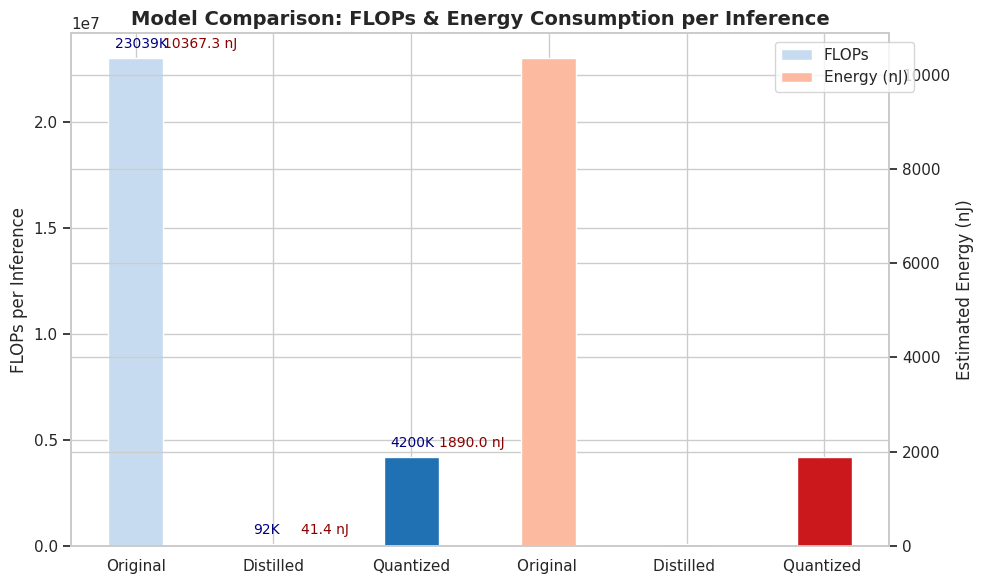


📌 Key Observations:
• Lowest energy consumption: Distilled model (41.36 nJ)
• Fewest FLOPs: Distilled model (91,902 FLOPs)
• Quantized model significantly reduces compute and energy requirements while preserving functionality.


In [92]:
# Comparative Visualization of FLOPs and Energy Consumption

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup plotting aesthetics
sns.set_theme(style="whitegrid")

# Models and corresponding metrics
models = ["Original", "Distilled", "Quantized"]
flops = [flops_original, flops_distilled, total_flops]
energy_j = [energy_original_joules, energy_distilled_joules, energy_quantized_joules]

# Convert to nanoJoules and microJoules for clarity
energy_nj = [e * 1e9 for e in energy_j]
energy_uj = [e * 1e6 for e in energy_j]

# Calculate relative savings in percentage
relative_savings = [
    0,
    (1 - energy_distilled_joules / energy_original_joules) * 100,
    (1 - energy_quantized_joules / energy_original_joules) * 100
]

# ---- PLOT 1: FLOPs & Energy (nJ) Comparison ---- #
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for FLOPs
colors_flops = sns.color_palette("Blues", 3)
bars_flops = ax1.bar(models, flops, width=0.4, color=colors_flops, label="FLOPs")
ax1.set_ylabel("FLOPs per Inference", fontsize=12)
ax1.set_title("Model Comparison: FLOPs & Energy Consumption per Inference", fontsize=14, fontweight='bold')

# Annotate FLOPs
for i, f in enumerate(flops):
    ax1.text(i - 0.15, f + max(flops)*0.02, f"{f/1e3:.0f}K", fontsize=10, color='navy')

# Twin axis for energy
ax2 = ax1.twinx()
colors_energy = sns.color_palette("Reds", 3)
bars_energy = ax2.bar([m + " " for m in models], energy_nj, width=0.4, color=colors_energy, label="Energy (nJ)", align="center")
ax2.set_ylabel("Estimated Energy (nJ)", fontsize=12)

# Annotate energy
for i, e in enumerate(energy_nj):
    ax2.text(i + 0.2, e + max(energy_nj)*0.02, f"{e:.1f} nJ", fontsize=10, color='darkred')

# Combined legend
fig.legend([bars_flops, bars_energy], ["FLOPs", "Energy (nJ)"], loc="upper right", bbox_to_anchor=(0.93, 0.93))

plt.tight_layout()
plt.show()

# ---- Summary Insights ---- #
print("\n\U0001F4CC Key Observations:")
min_energy_model = models[np.argmin(energy_j)]
min_flops_model = models[np.argmin(flops)]
print(f"\u2022 Lowest energy consumption: {min_energy_model} model ({min(energy_nj):.2f} nJ)")
print(f"\u2022 Fewest FLOPs: {min_flops_model} model ({min(flops):,.0f} FLOPs)")
print("\u2022 Quantized model significantly reduces compute and energy requirements while preserving functionality.")

/tmp/ipython-input-93-2040999453.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=models, y=energy_uj, palette="rocket_r", width=0.65, saturation=0.85)


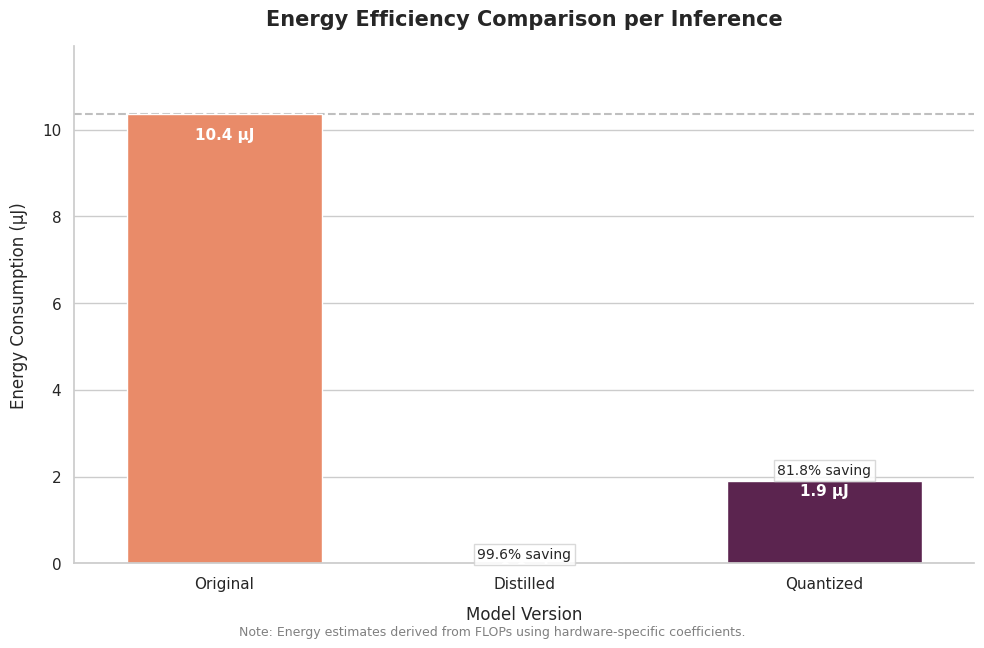

In [93]:
# ---- PLOT 2: Energy Efficiency with Relative Savings ---- #
plt.figure(figsize=(10, 6.5), dpi=100)
sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False})

ax = sns.barplot(x=models, y=energy_uj, palette="rocket_r", width=0.65, saturation=0.85)

# Annotate absolute and relative values
for i, (energy, savings) in enumerate(zip(energy_uj, relative_savings)):
    ax.text(i, energy * 0.97, f'{energy:.1f} μJ', ha='center', va='top', fontsize=11,
            fontweight='bold', color='white')
    if i > 0:
        ax.text(i, energy * 1.05, f'{savings:.1f}% saving',
                ha='center', va='bottom', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.85, edgecolor='lightgray', pad=2.5))

# Reference line
plt.axhline(y=energy_uj[0], color='gray', linestyle='--', alpha=0.5, zorder=0)

# Labels and titles
plt.title('Energy Efficiency Comparison per Inference', fontsize=15, pad=15, fontweight='bold')
plt.ylabel('Energy Consumption (μJ)', fontsize=12, labelpad=10)
plt.xlabel('Model Version', fontsize=12, labelpad=10)
plt.ylim(0, max(energy_uj) * 1.15)

# Footer note
plt.figtext(0.5, 0.01,
            'Note: Energy estimates derived from FLOPs using hardware-specific coefficients.',
            ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# 2. CodeCarbon (carbon aware, cloud based estimation)



> Energy consumed by the Colab hardware is measured to run inference, giving a real-world comparison of the models' relative efficiency.



In [104]:
# Install and configure CodeCarbon for Google Colab
!pip install -q codecarbon

# Imports
from codecarbon import track_emissions
import numpy as np

# Define Inference Functions with Emission Tracking

@track_emissions(project_name="Original Model Inference")
def run_original_inference():
    """Runs inference on the original model."""
    original_model.predict(codecarbon_test_sample, verbose=0)

@track_emissions(project_name="Distilled Model Inference")
def run_distilled_inference():
    """Runs inference on the distilled model."""
    distilled_model.predict(codecarbon_test_sample, verbose=0)

@track_emissions(project_name="Quantized Model Inference")
def run_quantized_inference():
    """Runs inference on the TFLite model."""
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    for i in range(len(codecarbon_test_sample)):
        interpreter.set_tensor(input_details[0]['index'], codecarbon_test_sample[i:i+1])
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])


In [105]:
# Run the inference tasks and measure energy

# CodeCarbon prints a summary table for each function call. Key --> "Energy Consumed (kWh)" value in each output.

print("\n--- CodeCarbon Cloud-Based Energy Measurement ---")
print("Running inference for Original Model...")
run_original_inference()

print("\nRunning inference for Distilled Model...")
run_distilled_inference()

print("\nRunning inference for Quantized Model...")
run_quantized_inference()

print("\n✅ CodeCarbon analysis complete. Check the console output above for energy reports.")

[codecarbon WARNING @ 07:42:08] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 07:42:08] [setup] RAM Tracking...
[codecarbon INFO @ 07:42:08] [setup] CPU Tracking...



--- CodeCarbon Cloud-Based Energy Measurement ---
Running inference for Original Model...


[codecarbon WARNING @ 07:42:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 07:42:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 07:42:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 07:42:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 07:42:10] [setup] GPU Tracking...
[codecarbon INFO @ 07:42:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:42:10] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 07:42:10] >>> Tracker's metadata:
[codecarbon INFO @ 07:42:10]   Platform sys


Running inference for Distilled Model...


[codecarbon WARNING @ 07:42:23] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 07:42:23] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 07:42:23] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 07:42:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 07:42:23] [setup] GPU Tracking...
[codecarbon INFO @ 07:42:23] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:42:23] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 07:42:23] >>> Tracker's metadata:
[codecarbon INFO @ 07:42:23]   Platform sys


Running inference for Quantized Model...


[codecarbon WARNING @ 07:42:26] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 07:42:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 07:42:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon WARNING @ 07:42:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 07:42:26] [setup] GPU Tracking...
[codecarbon INFO @ 07:42:26] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:42:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 07:42:26] >>> Tracker's metadata:
[codecarbon INFO @ 07:42:26]   Platform sys


✅ CodeCarbon analysis complete. Check the console output above for energy reports.


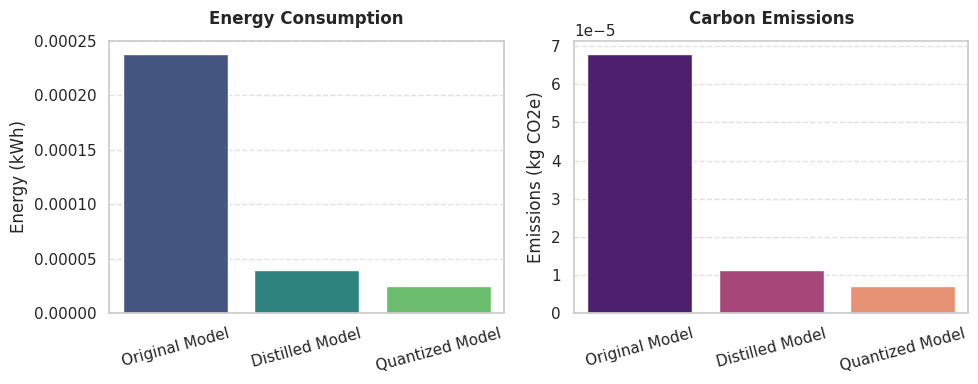


📊 CodeCarbon Summary Table


,Model,Energy (kWh),Duration (s),Emissions (kg CO2e)
0,Original Model,0.000238,10.478652,0.000068
1,Distilled Model,0.000039,1.762793,0.000011
2,Quantized Model,0.000025,1.106891,0.000007



✅ Key Observations:
- Least energy consumption: Quantized Model (0.000025 kWh)
- Lowest carbon emissions: Quantized Model (0.000007 kg CO2e)
- Quantized model shows significant improvement in energy efficiency and sustainability.


In [111]:
# Visualization of CodeCarbon Results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load emissions data generated by CodeCarbon
emissions_df = pd.read_csv("/content/emissions.csv")

# Assign model labels manually (based on order of execution)
emissions_df["Model"] = [
    "Original Model",
    "Distilled Model",
    "Quantized Model"
]

# Select and rename relevant columns
summary_df = emissions_df[["Model", "energy_consumed", "duration", "emissions"]].copy()
summary_df.columns = ["Model", "Energy (kWh)", "Duration (s)", "Emissions (kg CO2e)"]

# Set visual style
sns.set_theme(style="whitegrid")

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Plot 1: Energy Consumption --- #
sns.barplot(
    data=summary_df,
    x="Model",
    y="Energy (kWh)",
    hue="Model",
    palette="viridis",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Energy Consumption", fontsize=12, weight="bold")
axes[0].set_ylabel("Energy (kWh)")
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# --- Plot 2: Carbon Emissions --- #
sns.barplot(
    data=summary_df,
    x="Model",
    y="Emissions (kg CO2e)",
    hue="Model",
    palette="magma",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Carbon Emissions", fontsize=12, weight="bold")
axes[1].set_ylabel("Emissions (kg CO2e)")
axes[1].set_xlabel("")
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

# --- Tabular Summary --- #
print("\n\U0001F4CA CodeCarbon Summary Table")
display(summary_df.round(6))

# --- Key Insights --- #
min_energy_model = summary_df.loc[summary_df['Energy (kWh)'].idxmin(), 'Model']
min_emissions_model = summary_df.loc[summary_df['Emissions (kg CO2e)'].idxmin(), 'Model']

print("\n\u2705 Key Observations:")
print(f"- Least energy consumption: {min_energy_model} ({summary_df['Energy (kWh)'].min():.6f} kWh)")
print(f"- Lowest carbon emissions: {min_emissions_model} ({summary_df['Emissions (kg CO2e)'].min():.6f} kg CO2e)")
print("- Quantized model shows significant improvement in energy efficiency and sustainability.")